# Simulated Annealing Lab

In this lab I wrote a program for simulated annealing. 

I tested the program on a one-dimensional fitness surface with multiple local maxima. 
I also used the surface to study the effects of various annealing parameters on search efficiency. 
Finally, I will adapt the code to optimize a neural network to oscillate.

The lab was heavily influenced by: 
- [Lilian Besson's implementation](https://perso.crans.org/besson/publis/notebooks/Simulated_annealing_in_Python.html)

In [1]:
import numpy as np
from pandas import DataFrame
import math
import numpy.random as rn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import optimize
from __future__ import print_function, division #for compatibility

In [2]:
sns.set(context="talk", style="darkgrid", palette="hls", font="sans-serif", font_scale=1.05)
FIGSIZE = (19, 8) 
mpl.rcParams['figure.figsize'] = FIGSIZE

## Fitness Function
The goal of simulated annealing is to maximize the performance of a model relative to a fitness function defined over the model parameters we are seeking to optimize. In the next session, I apply simulated annealing to a one-dimensional problem in which I seek the value of X that maximizes the output of a function called fitnessFunction. But first let's write the code that implements the fitness function, the product of:
- m = 1+ cos(0.04*v)^2
- n = exp(−v^2 /(20000))

In [3]:
def fitnessFunction(v):
    m = 1 + np.cos(0.04*v)**2
    n = np.exp(- v**2 / 20000)
    return m*n

## Fitness Surface

When looking at the fitness surface, we notice several local maxima, which present a challenge in optimization. The global maximum is reached at x=0, for a value of 2. 

Text(0.5,1,'Fitness Surface')

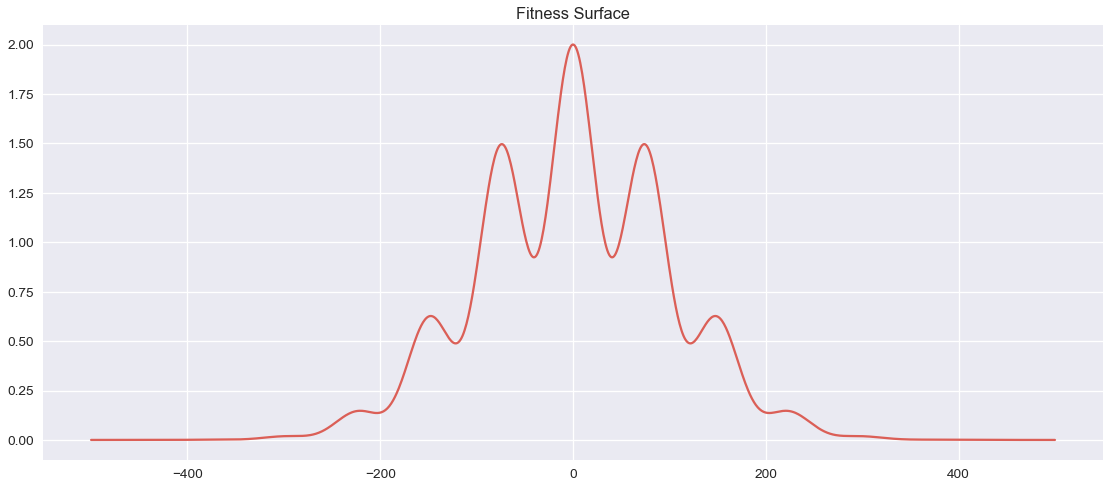

In [4]:
# x = 1000*rn.random_sample((1000,1))-500 #1000 random floats from -500 to 500
x = np.linspace(start=-500, stop=500, num=1000) #1000 floats from -500 to 500 
y = fitnessFunction(x)
plt.plot(x,y)
plt.title("Fitness Surface")

## First Algorithm, X_0 = 250, T = 10

Let's code the simulated annealing algorithm with an initial X value of 250 and an initial temperature of 10. Then we plot the trajectory of the annealing algorithm along the fitness surface. 

We'd like to slowly increase the temperature until we find the peak 90% of the time. For this we build a function that find the percentage of the time the peak is found. 

We'll report which temperature achieves this, and explain its significance in terms of the relationship between the search radius and the dimensions of the width of the fitness curve. 

### Algorithm

In [5]:
def annealing(start,
              cost_function,
              random_neighbour,
              acceptance,
              temperature,
              maxsteps=1000,
              debug=True):
    """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
    state = start()
    cost = cost_function(state)
    states, costs = [state], [cost]
    for step in range(maxsteps):
        fraction = step / float(maxsteps)
        T = temperature(fraction, t0)
        new_state = random_neighbour(state, fraction)
        new_cost = cost_function(new_state)
        if debug: print("Step #{:>2}/{:>2} : T = {:>4.3g}, state = {:>4.3g}, cost = {:>4.3g}, new_state = {:>4.3g}, new_cost = {:>4.3g} ...".format(step, maxsteps, T, state, cost, new_state, new_cost))
        if acceptance_probability(cost, new_cost, T) > rn.random():
            state, cost = new_state, new_cost
            states.append(state)
            costs.append(cost)
    return state, cost_function(state), states, costs

In [6]:
interval = (-500, 500)

def clip(x):
    """ Force x to be in the interval."""
    a, b = interval
    return max(min(x, b), a)

def start():
    """ Fixed start at 250 """ 
    return 250

def cost_function(x):
    """ Cost of x = f(x)."""
    return fitnessFunction(x)

def random_neighbour(x, fraction=1):
    """Move sligthly from x towards righ-handside or left-handside """
    amplitude = (max(interval) - min(interval)) * fraction / 5#changing this denominator number has a big impact
    delta = (-amplitude/2.) + amplitude * rn.random_sample()
    return clip(x + delta)

In [7]:
def acceptance_probability(cost, new_cost, temperature):
    # We're looking for global max, hence the direction of the inequality
    if new_cost > cost: 
        return 1
    else:
        p = np.exp(- (cost - new_cost) / temperature) 
        #Note: p = np.exp(-(new_cost+cost)/temperature) converges incredibly well, but not 'legal'? 
        return p

In [8]:
def temperature(fraction, t0):
    """ Temperature initially set a 10, with update to ensure it goes to 0 at max_steps """
    return max(0.01, min(t0, t0 - t0*fraction))

### Testing

Let's start with a small number of steps and the debug mode on to check whether everything seems to be working correctly.

In [9]:
t0 = 10
annealing(start, cost_function, random_neighbour, acceptance_probability, temperature, maxsteps=30, debug=True);

Step # 0/30 : T =   10, state =  250, cost = 0.0749, new_state =  250, new_cost = 0.0749 ...
Step # 1/30 : T = 9.67, state =  250, cost = 0.0749, new_state =  251, new_cost = 0.0718 ...
Step # 2/30 : T = 9.33, state =  251, cost = 0.0718, new_state =  247, new_cost = 0.0862 ...
Step # 3/30 : T =    9, state =  247, cost = 0.0862, new_state =  256, new_cost = 0.055 ...
Step # 4/30 : T = 8.67, state =  256, cost = 0.055, new_state =  247, new_cost = 0.0842 ...
Step # 5/30 : T = 8.33, state =  247, cost = 0.0842, new_state =  252, new_cost = 0.0688 ...
Step # 6/30 : T =    8, state =  252, cost = 0.0688, new_state =  265, new_cost = 0.0339 ...
Step # 7/30 : T = 7.67, state =  265, cost = 0.0339, new_state =  246, new_cost = 0.0901 ...
Step # 8/30 : T = 7.33, state =  246, cost = 0.0901, new_state =  231, new_cost = 0.136 ...
Step # 9/30 : T =    7, state =  231, cost = 0.136, new_state =  240, new_cost = 0.112 ...
Step #10/30 : T = 6.67, state =  240, cost = 0.112, new_state =  251, new_c

In [10]:
#With more steps
state, c, states, costs = annealing(start, cost_function, random_neighbour, 
                                    acceptance_probability, temperature, maxsteps=1000, 
                                    debug=False)

print("Last state & cost: ",state, c)

Last state & cost:  3.691539378237678 1.977006531651401


### Visualizing

In [11]:
def see_annealing(states, costs):
    """ Display the states and the costs as a function of the number of iterations """
    plt.figure()
    plt.suptitle("Evolution of states and costs of the simulated annealing")
    plt.subplot(121)
    plt.plot(states, 'r')
    plt.title("States")
    plt.subplot(122)
    plt.plot(costs, 'b')
    plt.title("Costs")
    plt.show()

In [12]:
def see_annealing_fitness(states,costs):
    """ Display the fitness surface, as well as the costs as a function of states"""
    fig, ax = plt.subplots()
    ax.set_xlim(-500,500)
    plt.subplot(111)
    plt.plot(states, costs, 'y', alpha=0.7)
    #plt.plot([states[-1], costs[-1]], 'b') #last state & costs
    #plt.subplot(122)
    plt.plot(x,y, 'g')
    plt.title("Fitness Surface (green) & Annealing Algorithm (yellow)")
    plt.show()

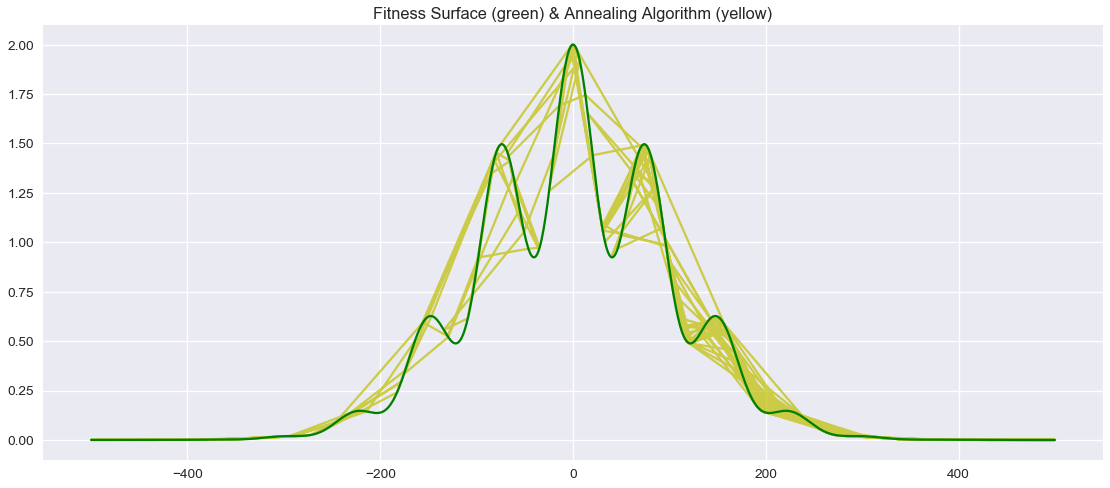

In [13]:
see_annealing_fitness(states,costs)

In [14]:
def peak_found_percentage(number_runs = 100):
    """ Number of times peak has been found """
    peak_found = 0
    for i in range(number_runs):
        state, c, states, costs = annealing(start, cost_function, random_neighbour, 
                                    acceptance_probability, temperature, maxsteps=1000, debug=False)
        if c >1.75: # this is somewhat arbitrary: all other maxima <= 1.5, 
            # if c >1.5 then it's in the region of the global max, 
            # and to see a difference in ratio between ≠ temp value
            peak_found += 1
    return peak_found/number_runs           

In [15]:
initial_temps = [10, 10.01, 10.02, 10.03,10.04, 
                 10.045,10.05,10.06, 10.1, 10.15, 10.2, 10.25, 10.30]
peak_found_percs = []
for i in initial_temps: 
    t0 = i
    peak_found_percs.append(peak_found_percentage())
data = {"Initial Temperature": initial_temps,
       "Peak Found %": peak_found_percs}
df = DataFrame(data, columns = ["Initial Temperature", "Peak Found %"])
df

,Initial Temperature,Peak Found %
0,10.000,0.86
1,10.010,0.86
2,10.020,0.87
3,10.030,0.85
4,10.040,0.79
5,10.045,0.81
6,10.050,0.85
7,10.060,0.78
8,10.100,0.83
9,10.150,0.84


When running 100 simulations with various temperatures, I found that most times, 10.04 & 10.045 yield the highest ratio of finding the peak.
I'm not quite sure how to interpret this in terms of search radius and dimension of the fitness curve. 

## Intermediate Best fitnesses vs. Iteration Number 

Another informative graph is the plot of all the intermediate best fitnesses versus iteration number.

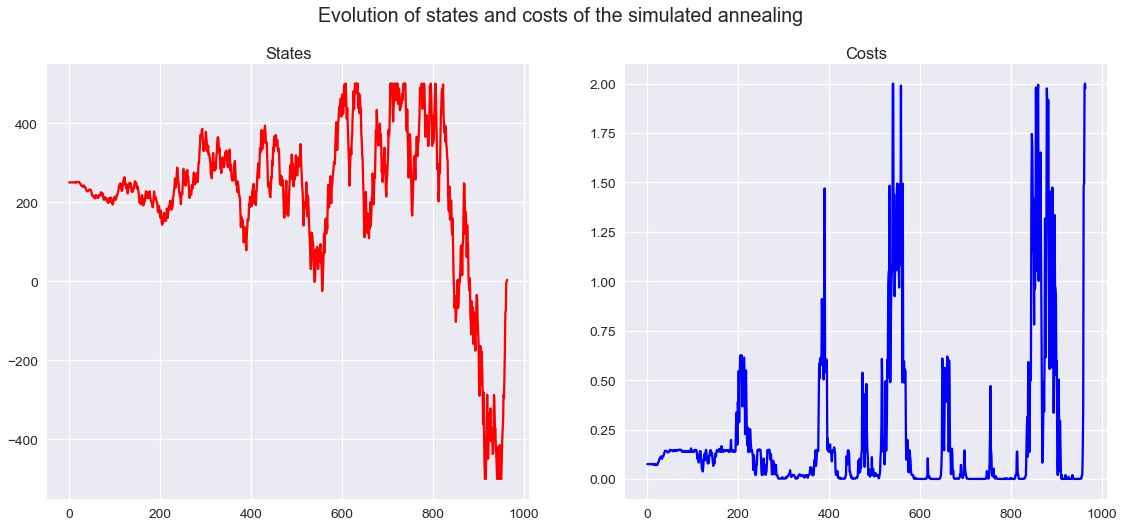

In [16]:
see_annealing(states,costs)

## 20 Simulations (Incomplete)
Let's now run simulation 20 times with each of 10 different values of temp shown. We'll plot the number of failures vs temperature and number of iterations to reach the peak vs temperature. 

In [17]:
initial_temps = [2,5,10,12,15,17,20,25,40,50]
peak_found_percs = []
for i in initial_temps: 
    r0=i
    peak_found_percs.append(peak_found_percentage(20))
data = {"Initial Temperature": initial_temps,
       "Peak Found %": peak_found_percs}
df = DataFrame(data, columns = ["Initial Temperature", "Peak Found %"])
df

,Initial Temperature,Peak Found %
0,2,1.00
1,5,0.60
2,10,0.85
3,12,0.80
4,15,0.90
5,17,1.00
6,20,0.75
7,25,0.80
8,40,0.95
9,50,0.85


## Conclusion

I've implemented a simulated annealing algorithm and tuned the initial temperature parameter to try and find the 'optimal' initial temperature, which was in this case 10.045. 


Next steps and potential improvements:
- Try different parameters (x_0, etc)
- Find out what the best initial temperature tuning means in terms of search radius and dimension of the fitness curve. 
- Research the 'mathematical' rule to define the peak has been reached
- Improve the simulated annealing vs. surface graph to showcase algorithm progress better
- Complete part 5
- Adapt the code to optimize a neural network to oscillate